In [12]:
import hashlib
import random

#For generation of the following: patient ID, MD5 Hashing of ID, AES key, and saving to a .tsv file
from Crypto.Random import get_random_bytes
from base64 import b64encode
import os

# For AES-GCM encrpytion and decryption
from Crypto.Cipher import AES
from base64 import b64decode

# For Unix Epoch Timestamp to be used for unique vcf file names
import time
import datetime

# For displaying context images
from IPython.display import Image



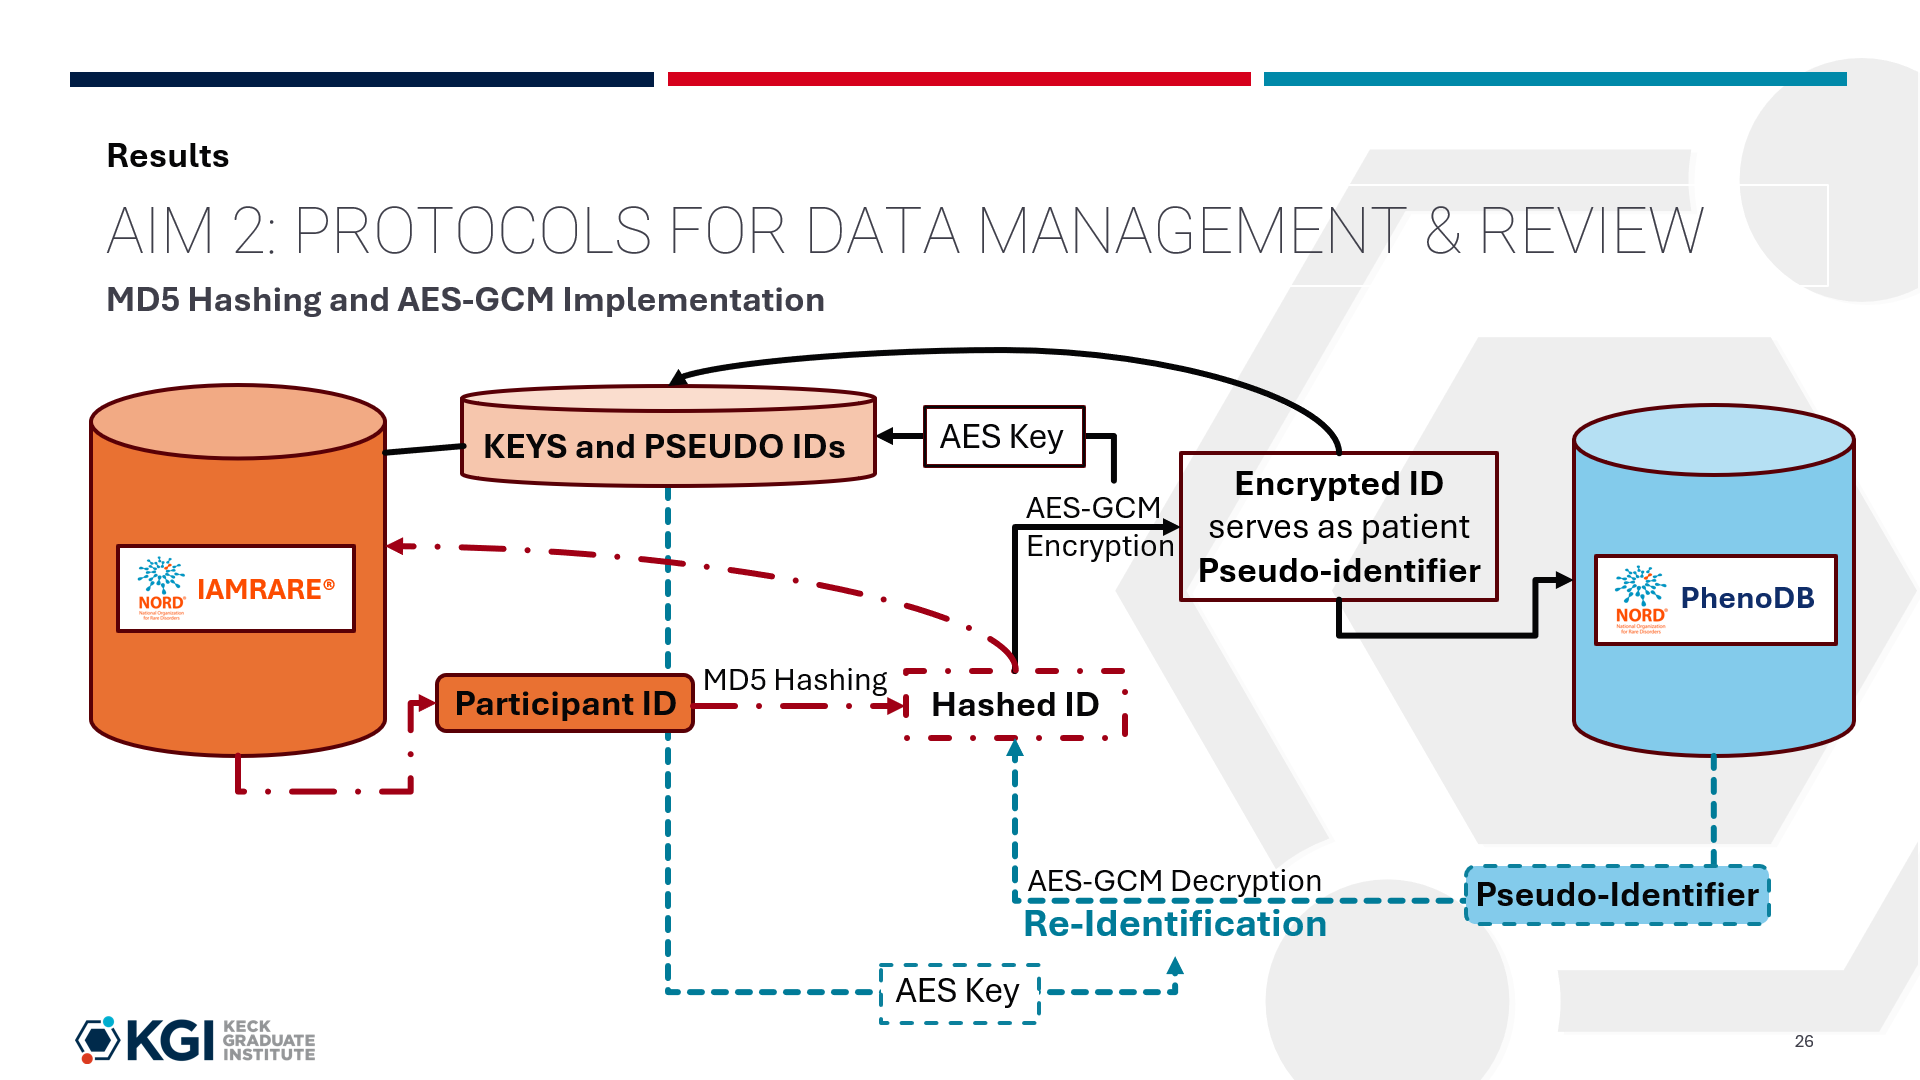

In [15]:
Image("MD5 Hashing and AES-GCM Implementation.png")

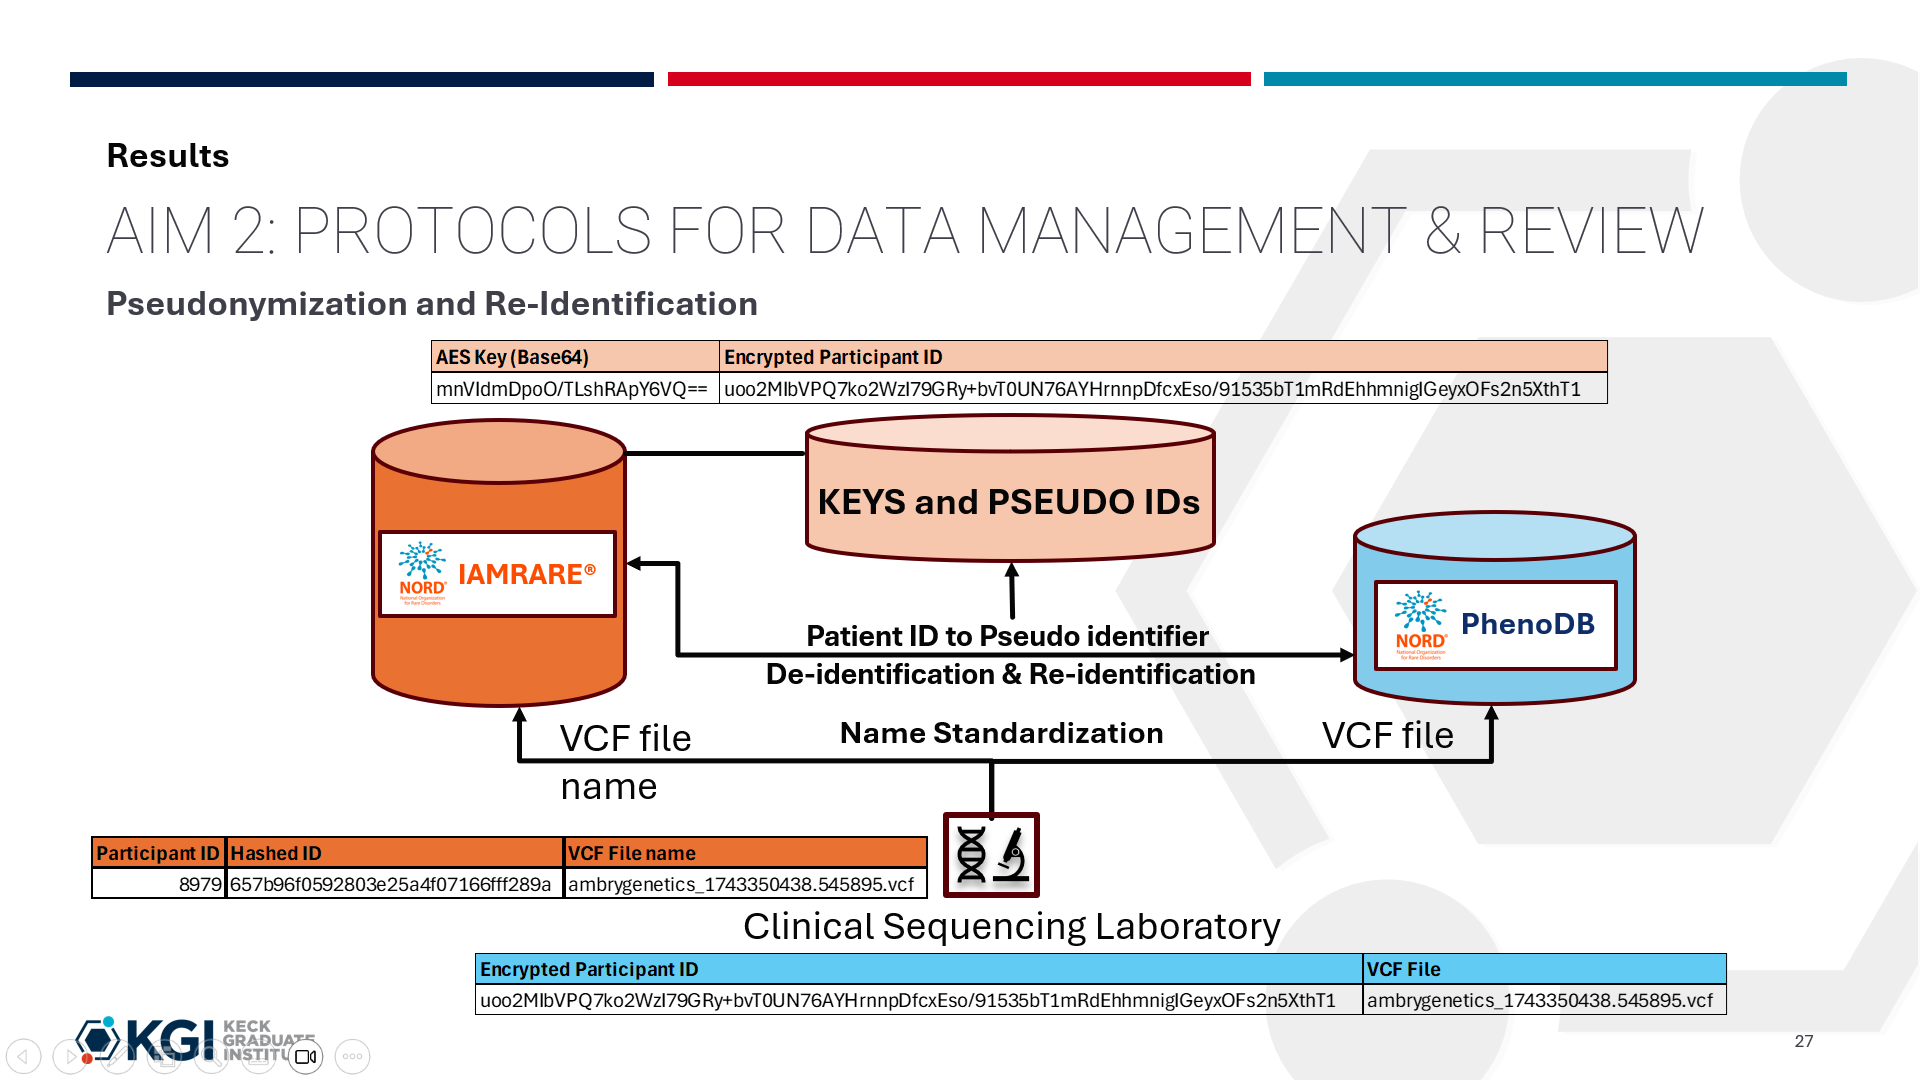

In [14]:
Image("Pseudonymization and Re-Identification Workflow.png")

## Section 1: Generate Patient ID, MD5 Hash, generate key then write to a .tsv file
1. Generates a random participant ID of type int and converts it to str
2. Hash the ID with MD5 turning it into a fixed-length 128-bit (32-character) string for added obfuscation and consistency
3. Generates a random 16-byte key for the AES algorithm
4. Saves the 3 generated "items" into a .tsv file called participant_data.tsv

In [5]:
# Generate participant ID
participant_ID = str(random.randint(0, 9999))
# print(f"Generated participant ID: {participant_ID}")

# Hash using MD5
m = hashlib.md5()
m.update(participant_ID.encode())  # Encode the string as bytes
hashed_participant_id = m.hexdigest()
# print(f"Hashed participant ID: {hashed_participant_id}")

# Generate a random 16-byte key for the AES algorithm
key = get_random_bytes(16)

# File path/name for output tsv file
participant_data_file = 'participant_data.tsv'

# Check if the file exists, if not, create the file and write headers
if not os.path.exists(participant_data_file):
    with open(participant_data_file, 'w') as file:
        file.write("Participant ID\tHashed ID\tAES Key (Base64)\n")  

# Save Participant ID, Hashed ID, and Key to the given tsv file
# NOTE: 'a' Opens in append mode
with open(participant_data_file, 'a') as file:  
    file.write(f"{participant_ID}\t{hashed_participant_id}\t{b64encode(key).decode()}\n")


## Section 2. Encrypt the Hashed Patient ID and Save to a Different TSV File
1. Create an encrypt function that is composed of the following:
    * Generate a 12-byte nonce to ensure that identical inputs produce different outputs
    * Create AES-GCM cipher object for encrytion with the given key, and nonce as additional inputs
2. Encrypts the given input text with the AES key and returns an encrypted text package consisting of the nonce, ciphertext, and tag
3. Saves the Hashed ID and encrypted text package into a tsv file called encrypted_participant_data.tsv

**NOTE: Use information from participant_data.tsv as inputs for the function. Inputs used for this are variables hashed_participant_id and key from section 1


In [ ]:

def encrypt(plaintext, key):

    """
    Encrypts a 128-bit (32 character string) using AES-GCM with a 12-byte generated nonce (number used once). Also requires a 16-byte key.
    The output is a concatenated Base64 string consisting of nonce, ciphertext, and tag.

    Accepts 2 inputs:
    plaintext = the MD5 hashed participant ID
    key = AES key
    """
    # Generate a random 12-byte nonce
    nonce = get_random_bytes(12)
    # print(f"Nonce:{nonce}")

    # Create AES-GCM cipher object
    cipher = AES.new(key, AES.MODE_GCM, nonce=nonce)
    
    # Encrypt and generate authentication tag
    ciphertext, tag = cipher.encrypt_and_digest(plaintext.encode())
    # print(f"Ciphertext:{ciphertext}")
    # print(f"Tag:{tag}")
    # Encode everything as Base64 for easy storage/transmission
    return b64encode(nonce + ciphertext + tag).decode()

# Encrypt the Hashed participant ID with the function created above
encrypted_participant_id = encrypt(hashed_participant_id, key)
# print(f"Encrypted (AES) participant ID: {encrypted_participant_id}")

# File path/name for saving encrypted data
encrypted_participant_data_file = 'encrypted_participant_data.tsv'

# Check if the file exists, if not, create the file and write headers
if not os.path.exists(encrypted_participant_data_file):
    with open(encrypted_participant_data_file, 'w') as file:
        file.write("Hashed ID\tEncrypted Participant ID\n")  

# Save Hashed ID and Encrypted Participant ID to a TSV file
with open(encrypted_participant_data_file, 'a') as file:
    file.write(f"{hashed_participant_id}\t{encrypted_participant_id}\n")


## Section 3. Decrypt the Encrypted Participant ID. 
* Asks for 2 inputs: Encrypted text (encrypted participant ID) and the encryption key
    * The function does the following:
        1. Decodes the Base65-encoded input
        2. Extracts the nonce, ciphertext, and authetication tag
        3. Decrypts the ciphertext using the AES key and nonce
        4. Verifies data integrity by looking at the tag
        5. Returns the original plaintext (Hashed participant ID) as a UTF-8 string
** NOTE: For inputs see participant_data.tsv for the key and encrypted_participant_data.tsv for the encrypted text


In [11]:
# Decrypt function as defined earlier
def decrypt(encrypted_text, key):

    """
    Decrypts a Base64-encoded string that was encrypted using AES-GCM with and a 16-byte key.

    Accepts 2 inputs:
        encrypted_text = the Base64-encoded string containing nonce + ciphertext + tag
        key = 16-byte AES key
    """
    # Decode Base64
    encrypted_data = b64decode(encrypted_text)

    # Extract nonce, ciphertext, and tag
    nonce = encrypted_data[:12]
    ciphertext = encrypted_data[12:-16]
    tag = encrypted_data[-16:]

    # Decrypt using the same nonce
    cipher = AES.new(key, AES.MODE_GCM, nonce=nonce)
    plaintext = cipher.decrypt_and_verify(ciphertext, tag)

    return plaintext.decode()

# Get AES key input from the user
key_input = input("Enter the AES key (Base64 encoded): ")
key = b64decode(key_input)  # Decode the input key from Base64

# Get the encrypted participant ID input from the user
encrypted_participant_id_input = input("Enter the encrypted participant ID: ")

# Decrypt the encrypted participant ID
decrypted_participant_id = decrypt(encrypted_participant_id_input, key)

# Print the decrypted participant ID
print(f"Decrypted Participant ID: {decrypted_participant_id}")


Decrypted Participant ID: c67ba7c4c5c0cd4cc3e3a7146fe5c015


# Unix epoch timestamp example

In [ ]:
timestamp = time.time()
print(timestamp)

1743886473.0361397


In [ ]:
dt_object = datetime.datetime.fromtimestamp(timestamp)
print(dt_object)

2025-04-05 13:54:33.036140
